In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import zipline
from zipline.api import (
    future_symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
    continuous_future,
    order_target,
    symbol,
)
from datetime import datetime
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np
from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import (
    VolumeShareSlippage,
    FixedSlippage,
    VolatilityVolumeShare,
)

<IPython.core.display.Javascript object>

In [3]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets

out = widgets.HTML()
display(out)

HTML(value='')

<IPython.core.display.Javascript object>

In [4]:
"""
Model Settings
"""
starting_portfolio = 50000000
risk_factor = 0.0015
stop_distance = 3
breakout_window = 50
vola_window = 40
slow_ma = 80
fast_ma = 40
enable_commission = True
enable_slippage = True  


<IPython.core.display.Javascript object>

In [5]:
def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = (
        np.power(
            context.portfolio.portfolio_value / starting_portfolio, 12 / context.months
        )
        - 1
    )

    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(
        today, context.months, ann_ret
    )

<IPython.core.display.Javascript object>

In [6]:
# We don't need this function because the quandl_chris bundle already uses continous data
def roll_futures(context, data):
    open_orders = zipline.api.get_open_orders()

    for held_contract in context.portfolio.positions:
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders:
            continue

        # Save some time by only checking rolls for
        # contracts stopping trading in the next days
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue

        # Make a continuation
        continuation = continuous_future(
            held_contract.root_symbol, offset=0, roll="volume", adjustment="mul"
        )

        # Get the current contract of the continuation
        continuation_contract = data.current(continuation, "contract")

        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount
            # Close current position
            order_target(held_contract, 0)
            # Open new position
            order_target(continuation_contract, pos_size)

<IPython.core.display.Javascript object>

In [7]:
def position_size(portfolio_value, std, point_value):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    # avoid division by zero
    contracts = (
        target_variation / contract_variation
        if contract_variation
        else target_variation
    )
    return int(np.nan_to_num(contracts))

<IPython.core.display.Javascript object>

In [8]:
def initialize(context):

    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)

    set_commission(us_futures=comm_model)

    if enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model = FixedSlippage(spread=0.0)

    set_slippage(us_futures=slippage_model)

    """
    Markets to trade
    """
    #     currencies = [
    #         "AD",
    #         "BP",
    #         "CD",
    #         "CU",
    #         "DX",
    #         "JY",
    #         "NE",
    #         "SF",
    #     ]

    #     agricultural = [
    #         "BL",
    #         "_C",
    #         "CT",
    #         "FC",
    #         "KC",
    #         "LR",
    #         "LS",
    #         "_O",
    #         "_S",
    #         "SB",
    #         "SM",
    #         "_W",
    #     ]
    #     nonagricultural = [
    #         "CL",
    #         "GC",
    #         "HG",
    #         "HO",
    #         "LG",
    #         "NG",
    #         "PA",
    #         "PL",
    #         "RB",
    #         "SI",
    #     ]
    #     equities = [
    #         "ES",
    #         "NK",
    #         "NQ",
    #         "TW",
    #         "VX",
    #         "YM",
    #     ]
    #     rates = [
    #         "ED",
    #         "FV",
    #         "TU",
    #         "TY",
    #         "US",
    #     ]

    #     # Make a list of all the markets
    #     markets = currencies + agricultural + nonagricultural + equities + rates

    markets = [
        "CME_EC1",
        "CME_E71",
        "CME_JY1",
        "CME_J71",
        "CME_AD1",
        "CME_BP1",
        "CME_CD1",
        "CME_SF1",
        "CME_NE1",
        "CME_CNH1",
        "CME_MP1",
        "CME_BR1",
        "CME_RA1",
        "CME_RU1",
        "CME_BO1",
        "CME_C1",
        "CME_KW1",
        "CME_O1",
        "CME_RR1",
        "CME_S1",
        "CME_SM1",
        "CME_W1",
        "CME_YC1",
        "CME_YK1",
        "CME_FC1",
        "CME_LC1",
        "CME_LN1",
        "CME_CB1",
        "CME_CSC1",
        "CME_DA1",
        "CME_DK1",
        "CME_DY1",
        "CME_NF1",
        "CME_BB1",
        "CME_CL1",
        "CME_CPO1",
        "CME_NG1",
        "CME_QG1",
        "CME_QL1",
        "CME_QM1",
        "CME_ES1",
        "CME_GA1",
        "CME_GI1",
        "CME_IBV1",
        "CME_JR1",
        "CME_MD1",
        "CME_ME1",
        "CME_N1Y1",
        "CME_ND1",
        "CME_NK1",
        "CME_NQ1",
        "CME_SP1",
        "CME_YM1",
        "CME_ALI1",
        "CME_GC1",
        "CME_HG1",
        "CME_HR1",
        "CME_MGC1",
        "CME_SI1",
        "CME_TIO1",
        "CME_ED1",
        "CME_EM1",
        "CME_FF1",
        "CME_I31",
        "CME_KI1",
        "CME_N1U1",
        "CME_NN1",
        "CME_SA1",
        "CME_TN1",
        "CME_UL1",
        "CME_US1",
    ]

    # not sure if this is needed since quandl_chris already uses continuos data
    # Make a list of all continuations
    #     context.universe = [
    #         continuous_future(market, offset=0, roll="volume", adjustment="mul")
    #         for market in markets
    #     ]
    context.universe = [symbol(market) for market in markets]

    # We'll use these to keep track of best position reading
    # Used to calculate stop points.
    context.highest_in_position = {market: 0 for market in markets}
    context.lowest_in_position = {market: 0 for market in markets}

    # Schedule the daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0

    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(),
    )

<IPython.core.display.Javascript object>

In [9]:
def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

<IPython.core.display.Javascript object>

In [10]:
def daily_trade(context, data):
    # Get continuation data
    hist = data.history(
        context.universe,
        fields=["close", "volume"],
        frequency="1d",
        bar_count=250,
    )

    # Calculate trend
    hist["trend"] = (
        hist["close"].ewm(span=fast_ma).mean() > hist["close"].ewm(span=slow_ma).mean()
    )

    # Make dictionary of open positions
    #     open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}
    open_pos = {pos.symbol: pos for pos in context.portfolio.positions}

    # Iterate markets, check for trades
    for continuation in context.universe:

        # Get root symbol of continuation
        #         root = continuation.root_symbol
        root = continuation.symbol

        # Slice off history for just this market
        h = hist.xs(continuation, 2)

        # Get standard deviation
        std = h.close.diff()[-vola_window:].std()

        if root in open_pos:  # Position is open

            # Get position
            p = context.portfolio.positions[open_pos[root]]

            if p.amount > 0:  # Position is long
                if (
                    context.highest_in_position[root] == 0
                ):  # First day holding the position
                    context.highest_in_position[root] = p.cost_basis
                else:
                    context.highest_in_position[root] = max(
                        h["close"].iloc[-1], context.highest_in_position[root]
                    )

                # Calculate stop point
                stop = context.highest_in_position[root] - (std * stop_distance)
                # Check if stop is hit
                if h.iloc[-1]["close"] < stop:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.highest_in_position[root] = 0
                # Check if trend has flipped
                elif h["trend"].iloc[-1] == False:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.highest_in_position[root] = 0

            else:  # Position is short
                if (
                    context.lowest_in_position[root] == 0
                ):  # First day holding the position
                    context.lowest_in_position[root] = p.cost_basis
                else:
                    context.lowest_in_position[root] = min(
                        h["close"].iloc[-1], context.lowest_in_position[root]
                    )

                # Calculate stop point
                stop = context.lowest_in_position[root] + (std * stop_distance)

                # Check if stop is hit
                if h.iloc[-1]["close"] > stop:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.lowest_in_position[root] = 0
                # Check if trend has flipped
                elif h["trend"].iloc[-1] == True:
                    contract = open_pos[root]
                    order_target(contract, 0)
                    context.lowest_in_position[root] = 0

        else:  # No position on
            if h["trend"].iloc[-1]:  # Bull trend
                # Check if we just made a new high
                if h["close"][-1] == h[-breakout_window:]["close"].max():
                    # contract = data.current(continuation, "contract")
                    contract = data.current(continuation, "price")

                    # contracts_to_trade = position_size(
                    #    context.portfolio.portfolio_value,
                    #    std,
                    #    contract.price_multiplier,
                    # )

                    contracts_to_trade = position_size(
                        context.portfolio.portfolio_value,
                        std,
                        1,
                    )

                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h["volume"][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)

                    # Place the order
                    # order_target(contract, contracts_to_trade)
                    order_target(symbol(root), -1 * contracts_to_trade)

            else:  # Bear trend
                # Check if we just made a new low
                if h["close"][-1] == h[-breakout_window:]["close"].min():
                    # contract = data.current(continuation, "contract")
                    contract = data.current(continuation, "price")

                    # contracts_to_trade = position_size(
                    #    context.portfolio.portfolio_value,
                    #    std,
                    #    contract.price_multiplier,
                    #    )

                    contracts_to_trade = position_size(
                        context.portfolio.portfolio_value,
                        std,
                        1,
                    )

                    # Limit size to 20% of avg. daily volume
                    contracts_cap = int(h["volume"][-20:].mean() * 0.2)
                    contracts_to_trade = min(contracts_to_trade, contracts_cap)

                    # Place the order
                    # order_target(contract, -1 * contracts_to_trade)
                    order_target(symbol(root), -1 * contracts_to_trade)

    # If we have open positions, check for rolls
    if len(open_pos) > 0:
        #         roll_futures(context, data)
        pass

<IPython.core.display.Javascript object>

In [11]:
start = pd.Timestamp("2001-01-01 08:15", tz="UTC")
end = pd.Timestamp("2019-01-02 08:15", tz="UTC")

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/usr/local/lib/python3.6/site-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2001-01-02
End date,2019-01-02
Total months,215
,Backtest
Annual return,39.6%
Cumulative returns,40265.3%
Annual volatility,2767.3%
Sharpe ratio,-0.27
Calmar ratio,0.16
Stability,NaN
Max drawdown,-244.2%


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,244.16,2016-01-25,2018-09-21,2018-12-24,761
1,206.76,2004-03-22,2004-09-13,2006-11-24,700
2,116.82,2002-01-02,2003-03-10,2003-10-02,457
3,81.96,2013-05-31,2014-07-22,2014-12-05,396
4,74.45,2018-12-24,2018-12-31,NaT,NaN


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute 

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
Th

CPU times: user 50min 26s, sys: 1min 22s, total: 51min 48s
Wall time: 51min 47s


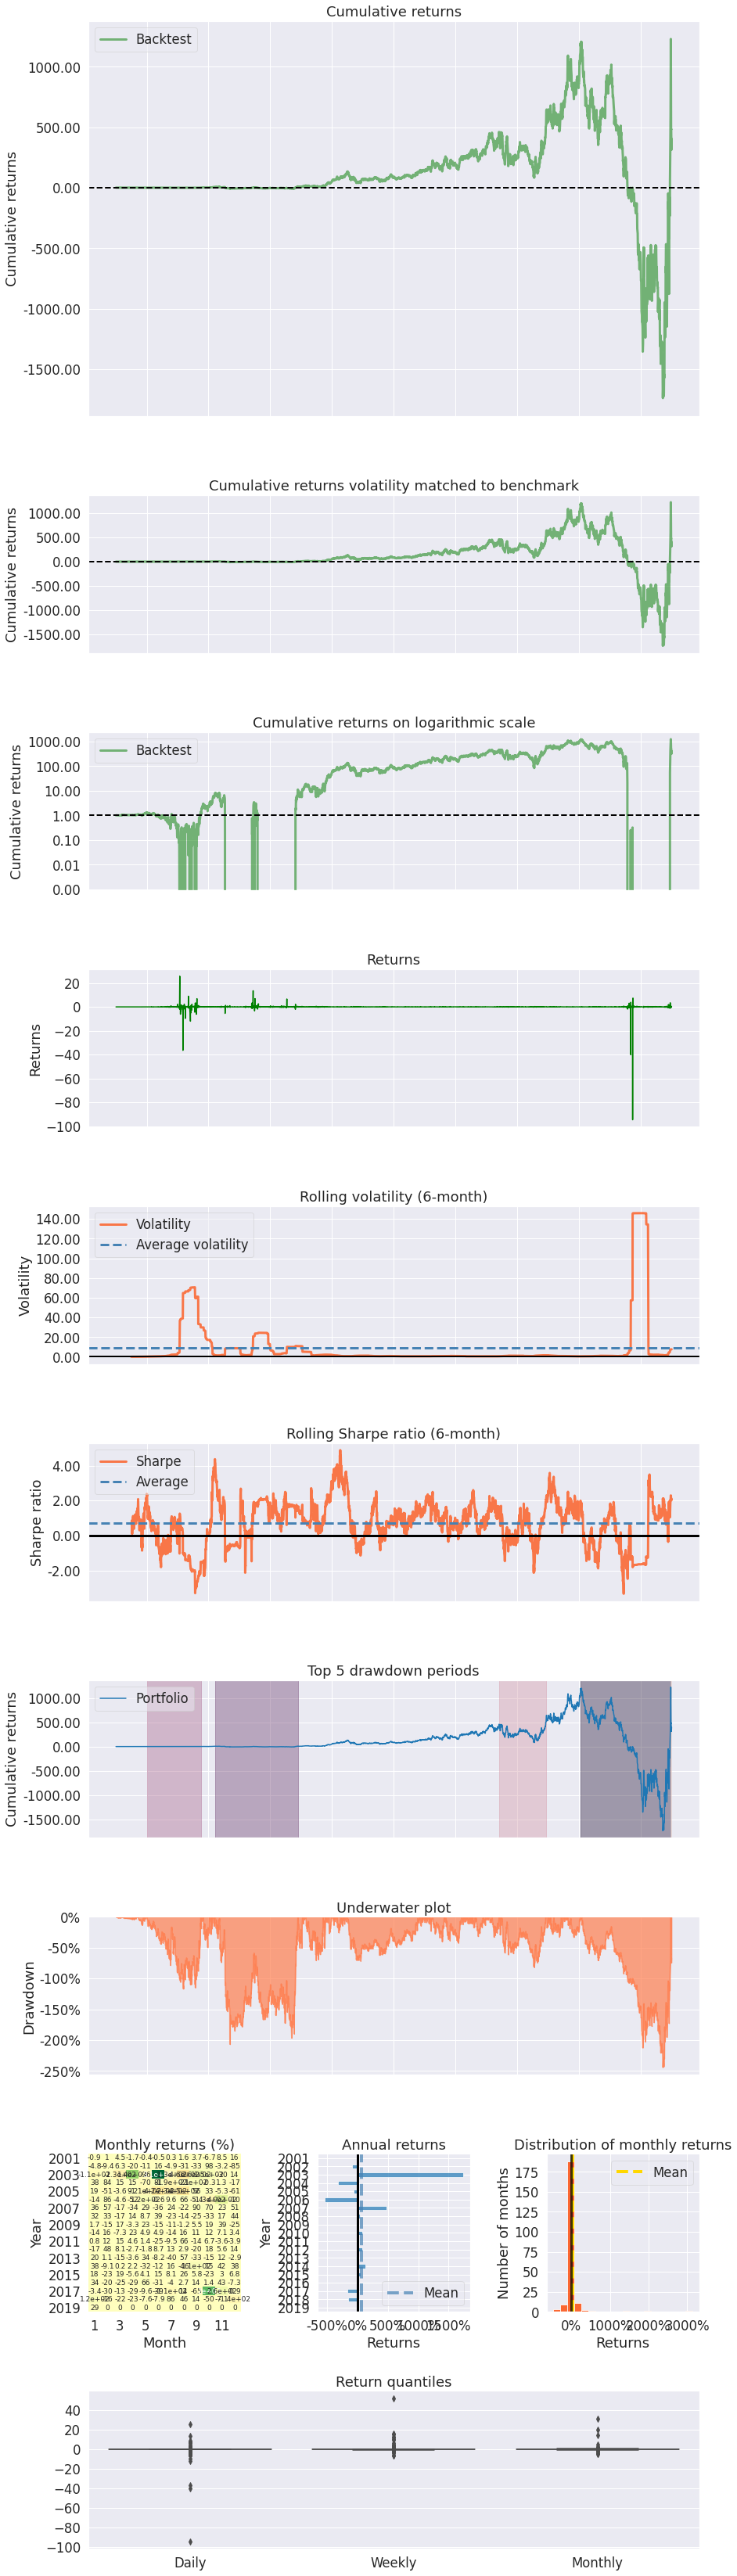

<IPython.core.display.Javascript object>

In [12]:
%%time
perf = zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    capital_base=starting_portfolio,
    data_frequency="daily",
    bundle="quandl_chris",
)